## Simple Monte Carlo

A posterior is already naturally factored into a likelihood function and a prior PDF.

## $$p(\theta|x) \propto p(x|\theta)\,p(\theta)$$

Applying this in the MC integration context leads to the Simple Monte Carlo algorithm:

```
while we want more samples
    draw theta from p(theta)
    compute weight = p(x|theta)
    store theta and weight
```

Note that you need to be given both $\theta$ and $x$ (the data).
Obtaining marginal distribution(s) for $\theta$ then reduces to constructing weighted histograms of the samples.

SMC is indeed simple (as long as the prior is simple to draw from), but if the priors are not very informative then it still wastes many likelihood evaluations where the posterior is small. 

However, refinements of this approach lead to some more advanced algorithms. Once class of refinements is in how the samples are drawn:

### Rejection sampling
For this method, we need to define an *envelope function* which everywhere exceeds the target PDF, $p(x)$, and can be sampled. Let this be $Ag(x)$ where $A$ is a scaling factor and $g(x)$ is a PDF we know.

Then the algorithm is
```
while we want more samples
    draw a random value for x from some distribution g(x) in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

# Problem 1: Rejection Sampling

Implement a rejection sampler corresponding to the example figure above that illustrates the method. For this example,

* $p(x)$ is the $\chi^2$ distribution with 3 degrees of freedom

* $A=\pi$

* $g(x)$ is a normal distribution with mean 0 and standard deviation 5

Verify that your samples do indeed approximate the target PDF.

Acceptance Fraction: 0.29
Acceptance Fraction: 0.32
Acceptance Fraction: 0.32


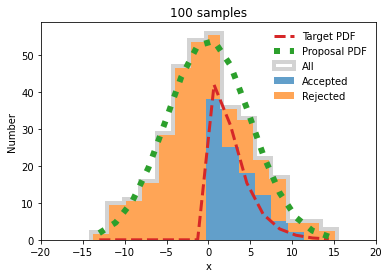

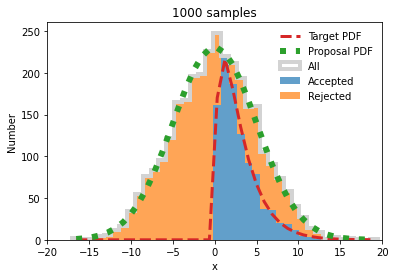

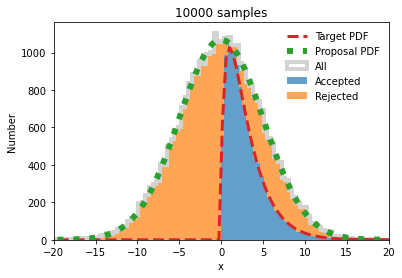

In [4]:
# Solution 1
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from astropy.visualization import hist as ahist

### comments with ### are just copied from the question - you can see that the code does what the text says

def rejection_sampling_demo(nsamp):
    samples = []
    bad_samples = []
    good_samp = 0 

    ### while we want more samples
    while good_samp < nsamp:
        
        ### draw a random value for x from some distribution g in the variable x
        x = st.norm.rvs(loc=0, scale=5, size=1)
        
        # the above isn't the best choice of proposing distribution, g(x)
        # any of these gives you a higher acceptance fraction
        # though you'll have be careful that the proposal distribution is higher than the target
        # everywhere, including the tails , so you might have to up the value of A
        
        #x = st.halfnorm.rvs(loc=0, scale=5, size=1)
        #x = st.halfcauchy.rvs(loc=0, scale=5, size=1)
        #x = st.expon.rvs(loc=0, scale=10, size=1)
        
        A = np.pi
        
        
        ### draw u from Uniform(0,1)
        u = st.uniform.rvs(loc=0, scale=1, size=1)
        
        ### if u <= p(x)/(A*g(x))
        fac = st.chi2.pdf(x, 3)/(A*st.norm.pdf(x, loc=0, scale=5))
        if u <= fac:
            ###  keep the sample x
            samples.append(x[0])
            good_samp+=1
        else:
            ### otherwise, reject x
            
            # actually, we're going to keep a track of where the bad samples are
            bad_samples.append(x[0])
            continue 

    # of course if we combine good and bad samples, then everything should be from the same PDF
    all_samples = samples + bad_samples

            
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # step plot of all the samples - I'm only doing this to get a consistent set of bins
    _, bins, _ = ahist(all_samples, bins='freedman', color='lightgray', histtype='step', lw=4, zorder=0, label='All')
    
    # now that we have the bins that work for the entire sample, we can evaluate both accepted and rejected
    good_vals, _ = np.histogram(samples, bins=bins)
    bad_vals, _ = np.histogram(bad_samples, bins=bins)
    
    # get bin widths and centers
    widths = np.diff(bins)
    bin_centers = (bins[0:-1] + bins[1:])/2.
    
    # stacked bar plots of good and bad values - i.e. histograms the manual way
    ax.bar(bin_centers, height=good_vals, width=widths, color='C0', alpha=0.7, label='Accepted', zorder=-1)
    ax.bar(bin_centers, height=bad_vals, bottom=good_vals, width=widths, color='C1',\
               alpha=0.7, label='Rejected', zorder=-2)

    
    # We also overplot the distribution - renormalize the area
    pdf = st.chi2.pdf(bin_centers, 3)
    pdf *= (nsamp/np.sum(pdf))
    
    prop_pdf = st.norm.pdf(bin_centers, loc=0, scale=5)
    prop_pdf *= (len(all_samples)/np.sum(prop_pdf))
    
    # plot the distribution
    ax.plot(bin_centers, pdf, lw=3, color='C3', ls='--', label='Target PDF')
    ax.plot(bin_centers, prop_pdf, lw=6, color='C2', ls=':', label='Proposal PDF')
    
    # tidy up our work
    ax.set_xlabel('x')
    ax.set_ylabel('Number')
    ax.set_title(f'{nsamp} samples')
    ax.legend(frameon=False, loc='upper right')
    ax.set_xlim(-20, 20)
    
    accept_fraction = len(samples)/len(all_samples)
    print(f'Acceptance Fraction: {accept_fraction:.02f}')
    return fig, samples

    
for nsamp in np.logspace(2, 4, num=3):
    rejection_sampling_demo(int(nsamp))

### This is the trick - as long as you know the function you actually want samples from (even if it's some messy, non-invertible thing), then you can sample some *other* distribution like a Gaussian and still get representative sample from the **target** distribution, as long as you can find an envelope function (even a constant like pi) that completely covers your target distribution. 

### This may not be a very efficient way of generating samples (see the quantity rejected - also the points outside of the circle in your in-class exercise in week 4, but it has the great benefit of working without derivatives for whatever you throw at it.

### You can get it to be more efficient with a good choice of the proposal distribution. 

This technique is at the heart of a  very widely used (by scientists anyway) and simple to implement technique: the **Metropolis-Hastings** algorithm, which is one example of *Markov Chain Monte Carlo.*

### Markov Chains

A Markov Chain is a sequence where the $n$th entry depends explicitly on the $(n-1)$th, but not (explicitly) on previous steps. The chain will be a random walk through parameter space.


### Formalities of MCMC

Markov chains provide a powerful way to sample PDFs, provided that the transition kernel/proposal distribution - how we go from state 1 to state 2  satisfies a few requirements
* Detailed balance: any transition must be reversible; the probability of being at $x$ and moving to $y$ must equal the probability of being at $y$ and moving to $x$
* Ergodicity: the process may not be periodic, but it nevertheless must be possible to return to a given state in finite time
* It must be possible, in principle, to reach any state with non-zero prior probability

#### Why does it work?
The probability of an arbitrary point from such a chain being located at $x'$ is (marginalizing over the possible immediately preceding points)

## $$p(x') = \int dx \, p(x) \, T(x'|x)$$

where $T(x'|x)$ is the transition probability of a step from $x$ to $x'$.

If we have detailed balance, 

## $$p(x)T(x'|x) = p(x')T(x|x')$$

rearranging:

## $$ \frac{T(x'|x)}{T(x|x')} = \frac{p(x')}{p(x)} $$

The basic trick to connect this with rejection sampling is to break the transition into two steps:
1. A proposal, g(x'| x)
and 
2. Acceptance ratio, A(x'|x)

i.e. 

## $$ T(x'|x) = A(x'|x) g(x'| x) $$ 

rearranging again :

## $$ \frac{A(x'|x)}{A(x|x')} = \frac{p(x')g(x|x')}{p(x)g(x'|x) }$$


## Metropolis-Hastings
This algorithm can be thought of as an MCMC adaptation of rejection sampling. We need to define
1. An initial state (parameter values)
2. A proposal distribution, $g(x'|x)$, giving the probability that we attempt to move from $x$ to $x'$.

Let $P$ be the distribution we want to sample. The algorithm is then
```
set x to an initial state
compute p(x)
while we want more samples
    draw x' from the proposal distribution g(x'|x)
    compute p(x')
    draw u from Uniform(0,1)
    if u <= p(x')/p(x) * g(x|x')/g(x'|x), set the state x=x'
    otherwise, x stays the same
    store x as a sample
```

Compare this to the rejection sampling algorithm above!

Notice that the probability of accepting a step  (once it's proposed) is

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')g(x|x')}{p(x)g(x'|x)}\right]$$

Let's look again at the requirement of detailed balance

> the probability of being at $x$ and moving to $y$ must equal the probability of being at $y$ and moving to $x$

The first of these is $p(x)g(x'|x)A(x',x)$, where

* $p(x)$ is the posterior density (probability of *being* at $x$, if we're sampling $P$ properly)

* $g(x'|x)$ is the proposal distribution (probability of attempting a move to $x'$ from $x$)

* $A(x',x)$ is the probability of accepting the proposed move

With this definition of $A$, detailed balance is automatically satisfied!

## $$p(x)g(x'|x)A(x',x) \equiv p(x')g(x|x')A(x,x')$$

Note that **even if a step is rejected, we still keep a sample** (the original state, without moving). The difficulty of finding a temptingly better point is important information!


### Metropolis
If the proposal distribution is translation invariant (i.e. only depends on the distance between the points), $g(x'|x)=g\left(\left|x'-x\right|\right)$, then it drops out of the *acceptance ratio* that decides whether to accept a step. 

**The most basic choice you can make is a Gaussian.**

For an N-dimensional Gaussian proposal function, $g$,  an *acceptance fraction* $A$ of $\sim25\%$ is optimal.

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')}{p(x)}\right]$$

This is the original Metropolis algorithm, and is the easiest case to implement.

In this case, we *always* accept a jump to higher $p$, and *sometimes* accept one to lower $p$.

You'll have to tune the $\sigma$ of your Gaussian proposal function g by hand to make sure that your get a ~25% acceptance ratio. Note that this sigma is simply telling you the distribution of $x'$ from $x$.

# Problem 2: Metropolis


You guessed it... Implement the Metroplis Hastings algorithm in python.
Your implementation should accept an arbitary function as an argument (just as you've been passing to `scipy.optimize`)

Test it by sampling both the `circle` and `pgauss` function below 10,000 times and plotting your samples as you did in class (don't plot up your rejected). You can implement a prior function that imposes bounds. 

Look at your first 100 samples and then samples 500 to 600 for the `pgauss` case and comment on the difference. Think about this on Problem 3!

### First, we'll create a MH sampler that deviates a little from what the question asks, but has the virtue of being easier to understand. Instead of using a gaussian proposal distribution we'll use a uniform U(-1, 1) distribution for each parameter - i.e. our random walker can move up to one unit in any direction. We'll also ignore different step sizes in different dimensions.

### This has the benefit of being easy to read.

In [6]:
# solution 2
import os
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


### Before we make a clean solution to this problem, let's just simplify the process
### We can make the proposal distribution g(x) whatever the heck we want
### If we make g(x) a uniform distribution then the ratio g(x|x')/g(x'|x) = 1
### then we can simplify the algorithm a little
### To make life even simpler, lets simply allow the step size in all directions to be of order unity

def very_simple_metropolis_hastings(p, x0, nsamp=1000):
    
    # here's our initial position
    x, y = x0
    
    # we need something to save the samples we want
    samples = np.zeros((nsamp, 2))

    # while we want more samples
    for i in range(nsamp):

        # now we adjust the initial position a little
        x_star, y_star = np.array([x, y]) + st.uniform.rvs(loc=-1, scale=2, size=2)
        
        ### draw u from Uniform(0,1)
        ### and compare it to the ratio of p(x) - our choice of g(x) makes that part drop out
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star
            
        # we save the sample to the chain
        samples[i] = np.array([x, y])
    return samples

### Next, we'll wrap the sampler in some code that will plot the samples and traceplots in 2-dimensions. 

In [7]:
def mh_demo(p, x0, nsamp=1000):
    plt.ioff()
    samples = very_simple_metropolis_hastings(p, x0, nsamp=nsamp)

    # traceplots and sample plot as an animation
    
    # create some axes
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax0, ax1, ax2 = axs
    xdata, ydata = [], []
    
    # plot all the data in grey
    ax0.scatter(samples[:, 0], samples[:, 1], color='grey', alpha=0.1, marker='.')
    ax1.plot(samples[:, 0], marker='.', color='grey', alpha=0.1, ls='-')
    ax2.plot(samples[:, 1], marker='.', color='grey', alpha=0.1, ls='-')
    
    # init some objects that will hold each frame of the animation
    ln0, = ax0.plot([], [],  ls ='None', marker='o', color='r')
    ln1, = ax1.plot([], [],  ls ='None', marker='o', color='r' )
    ln2, = ax2.plot([], [],  ls ='None', marker='o', color='r' )
    
    # initalize the animation
    def init():     
        ax0.set_xlim(samples[:, 0].min()-0.5, samples[:,0].max()+0.5)
        ax0.set_ylim(samples[:, 1].min()-0.5, samples[:,1].max()+0.5)
        ax1.set_xlim(-1, len(samples))
        ax2.set_xlim(-1, len(samples))
        ax1.set_ylim(samples[:, 0].min()-0.5, samples[:,0].max()+0.5)
        ax2.set_ylim(samples[:, 1].min()-0.5, samples[:,1].max()+0.5)
        ax0.set_ylabel('y')
        ax0.set_xlabel('x')
        ax1.set_ylabel('x')
        ax2.set_ylabel('y')
        ax1.set_xlabel('Step')
        ax2.set_xlabel('Step')
        return ln0, ln1, ln2

    # update ever sample
    def update(sample):
        xdata.append(sample[0])
        ydata.append(sample[1])
        ln0.set_data(xdata, ydata)
        # we're animating only every 10th step because 1,000 frames is a lot of frames!
        ln1.set_data(np.arange(0, 10*len(xdata), 10), xdata)
        ln2.set_data(np.arange(0, 10*len(ydata), 10), ydata)
        return ln0, ln1, ln2
    
    # animate every 10th step
    anim = FuncAnimation(fig, update, frames=samples[::10,:], init_func=init, blit=True, interval=100, save_count=0)
    
    # save a copy for git
    outname = p.__name__ + f'_{x0[0]}_{x0[1]}.mp4'
    extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p']
    if not os.path.exists(outname):
        anim.save(outname, extra_args=extra_args)
        
    return anim

In [8]:
# these are just the definitions of the functions in the homework
# they're from Numerical Recipes and you will see these over and over and over...

def circle(x, y):
    return (x-1)**2 + (y-2)**2 - 3**2

mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])

def pgauss(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mus, cov=sigmas)

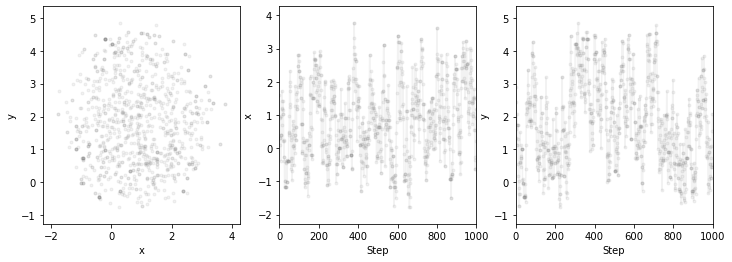

In [10]:
### set x to an initial state and sample
x0 = [1, 2]

anim = mh_demo(circle, x0, nsamp=1000)

<video controls src="circle_1_2.mp4" />

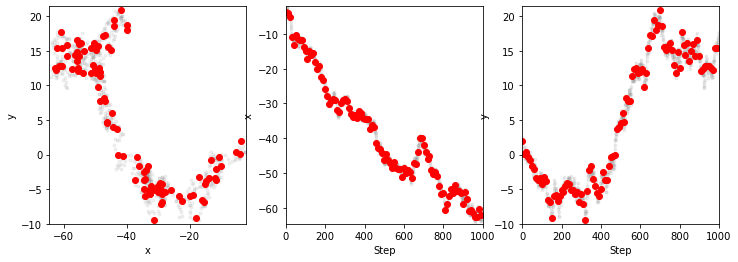

In [13]:
### let's see what happens if we pick an initial position outside the circle
x0 = [-3, 2]

# if you want interactive animations, uncomment these lines
anim = mh_demo(circle, x0, nsamp=1000)

<video controls src="circle_-3_2.mp4" />

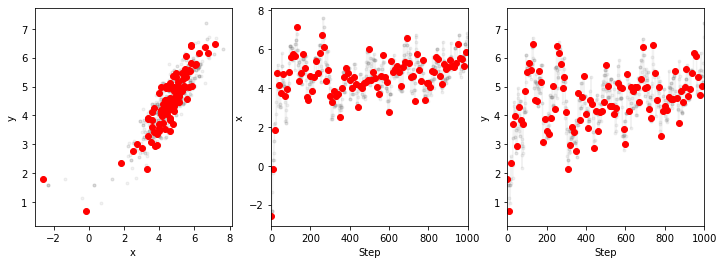

In [15]:
###  and then let's look at pgauss

anim = mh_demo(pgauss, x0, nsamp=1000)

<video controls src="pgauss_-3_2.mp4" />

### Our Metropolis-Hastings code is a total of 7 lines, and can sample arbitrary functions even if they are non-linear (like a circle!)


### As with rejection sampling, the choice of proposal function matters. Now that we are dealing with a chain, the initial position also matters. These are the only two quantities that define the Markov Chain - where we start, and how we move.


### Make poor proposals or a poor initial guess and the chain may never be stationary.


### Finally, we'll improve our MH code a little

In [17]:
def metropolis_hastings(p, x0, sigma, *args, nsamp=1000):
    
    ndim = len(x0)
    try:
        test_val = p(*x0, *args)
        if not np.isfinite(test_val):
            raise ValueError('Function at starting position is not finite')
        
        if test_val == 0.:
             raise ValueError('Function at starting position must be non-zero')
                
    except Exception as e:
        message = f'{e}\nCannot initialize sampler at this position'
        raise ValueError(message)
    
        
    # we need something to save the samples we want
    samples = np.zeros((nsamp, ndim))    

    x = np.array(x0)
    sigma = np.array(sigma)
    
    # the position and step size arrays had better be the same 
    assert x.shape == sigma.shape, 'Shape of x and shape of sigma must be the same'
    
    # while we want more samples
    for i in range(nsamp):

        # now we adjust the initial position a little
        # instead of explictly definition g(x|x') and g(x'|x)
        # we can recognize that a Gaussian is a stationary kernel
        # as we discussed in class, this is nice because 
        # all that matters is the absolute difference between x' and x
        # and if that's the case, then g(x'|x) = g(x|x')
        x_prime = x + sigma*np.random.randn(ndim)


        if np.random.rand() < (p(*x_prime, *args) / p(*x, *args)):
            x = x_prime
            
        # we save the sample to the chain
        samples[i] = x
    return samples

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


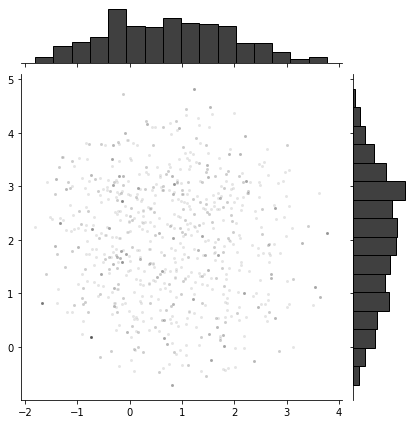

In [18]:
x0 = [1, 2]
sigma=[1.1, 0.9]
nsamp=1000

samples = metropolis_hastings(circle, x0, sigma, nsamp=nsamp)
sns.jointplot(samples[:, 0], samples[:, 1], color='k', alpha=0.1,marker='.')

## Next HW: Using your sampler for a real problem where a grid would have been really painful.